In [1]:
!git config user.email "naazshafeer@gmail.com"
!git config user.name "Naaz Shafeer"

This notebook is made to show the changes in the dynamical friction component
I will organize the test with, first:
- all the init
- all the functions
- plots from different perspectives
- Theoretical v Simulated Orbit Time
- KE, PE, and Total Energy Diagrams
- Error with Orbit Times

Initialization of the Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

In [34]:
plt.rcParams['font.family'] = 'Times New Roman'
# region Code Snippet 1: IC's
G = const.G #change the innate time to years
m_gal = 1e21 * const.M_sun
#Masses
m1=1e6 * const.M_sun #mass of black hole A 
m2=1e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
mu = G.value * (m1.value+m2.value)
#r_i
r1=[1e3,0,0] * u.pc
r2=[-1e3,0,0] * u.pc
#To arrays
r1=np.array(r1,dtype="float64") * u.pc
r2=np.array(r2,dtype="float64") * u.pc

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)
#V_i
v1=[0,0.25e3, 0] *u.km/u.s
v2=[0,-0.25e3,0] *u.km/u.s #km/s

# v1 = v1.to(u.m / u.year)
# v2 = v2.to(u.m / u.year)

#To arrays
v1=np.array(v1,dtype="float64") *u.km/u.s
v2=np.array(v2,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

r=np.linalg.norm(r2-r1)

a1 = (np.linalg.norm(r2 - r1) / 2)
o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
x = (a1 * o**(2)) / (G * m1)

ln_A = math.log10(x.to_value(u.dimensionless_unscaled))

F_D = 0.428 * ln_A * ((G * m1**(2))/r**(2))

v_r = v2 - v1

v_rmag = np.linalg.norm(v_r) 

v_rel_unit = (v_r / v_rmag)

F_D_i = (F_D * v_rel_unit[0])
F_D_j = (F_D * v_rel_unit[1])
F_D_k = (F_D * v_rel_unit[2])
    
F_D = np.array([F_D_i.to((u.kg*u.m)/(u.s**2)).value, F_D_j.to((u.kg*u.m)/ (u.s**2)).value, F_D_k.to((u.kg*u.m)/ (u.s**2)).value])

    



F_D = F_D * ((u.kg * u.m)/(u.s**2))
    
T = 10 * u.Gyr # we can extract a from here - whole time in seconds
N = 500
delta_t = T/ N
    # a1 = (F_D/m1).to(u.km/u.s**2)
    # a2 = (F_D/m2).to(u.km/u.s**2)
    # delta_t = delta_t.to(u.s)

F_D1 = (F_D / m1).to(u.km / u.s**2)
F_D2 = (F_D / m2).to(u.km / u.s**2)

dv1bydt=G*m2*(r2-r1)/r**3 - F_D1
dv2bydt=G*m1*(r1-r2)/r**3 - F_D2
dr1bydt = v1  # maybe we don't need df subtraction here
dr2bydt = v2 
r_derivs=np.concatenate((dr1bydt.value,dr2bydt.value))
derivs=np.concatenate((r_derivs,dv1bydt.value,dv2bydt.value))

time_span=np.linspace(0, T, N) #Work on this with Kris' link

# endregion



In [4]:
# i hope this works

Functions

In [5]:
# We first start with the CFL check (to see if the time steps + time used for the project don't cause instability)

def verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2):
    max_speed = max(np.linalg.norm(v1), np.linalg.norm(v2))
    min_distance = np.linalg.norm(r2 - r1)
    cfl = max_speed * delta_t / min_distance
    print(f"CFL Value: {cfl}")
    return cfl <= 1

#Then we have the dynamical friction functions
def semi_major_axis(r1, r2):
    a1 = (np.linalg.norm(r2 - r1) / 2)
    return a1
# this will be in pc
def sigma(m_gal):
    o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
    return o

# this will be in km/s
def coulomb(a1, o, G, m1):
    x = (a1 * o**(2)) / (G * m1)
    # ln_A = math.log10(x.to(""))
    ln_A = math.log10(x.to_value(u.dimensionless_unscaled))
    return ln_A
#should be unitless
def DF(v1, v2, ln_A, G, m1, r):
    F_D = 0.428 * ln_A * ((G * m1**(2))/r**(2))

    v_r = v2 - v1

    v_rmag = np.linalg.norm(v_r) 

    v_rel_unit = (v_r / v_rmag)

    F_D_i = (F_D * v_rel_unit[0])
    F_D_j = (F_D * v_rel_unit[1])
    F_D_k = (F_D * v_rel_unit[2])
    
    # np.array([F_D_i.value, F_D_j.value, F_D_k.value])

    return np.array([F_D_i.to((u.kg*u.m)/(u.s**2)).value, F_D_j.to((u.kg*u.m)/ (u.s**2)).value, F_D_k.to((u.kg*u.m)/ (u.s**2)).value])

def TwoBodyEquations(w,t,G,m1,m2, m_gal):
    r1=w[:3] * u.pc
    r2=w[3:6] * u.pc
    v1=w[6:9] * u.km/u.s
    v2=w[9:12] * u.km/u.s
    
    r=np.linalg.norm(r2-r1)

    a1 = semi_major_axis(r1, r2)
    o = sigma(m_gal)
    ln_A = coulomb(a1, o, G, m1) 
    F_D = DF(v1, v2, ln_A, G, m1, r) * ((u.kg * u.m)/(u.s**2))
    
    T = 10 * u.Gyr # we can extract a from here - whole time in seconds
    N = 50000
    delta_t = T/ N
    # a1 = (F_D/m1).to(u.km/u.s**2)
    # a2 = (F_D/m2).to(u.km/u.s**2)
    # delta_t = delta_t.to(u.s)

    F_D1 = (F_D / m1).to(u.km / u.s**2)
    F_D2 = (F_D / m2).to(u.km / u.s**2)
    dv1bydt=G*m2*(r2-r1)/r**3 - F_D1
    dv2bydt=G*m1*(r1-r2)/r**3 - F_D2
    dr1bydt = v1  # maybe we don't need df subtraction here
    dr2bydt = v2 
    r_derivs=np.concatenate((dr1bydt.value,dr2bydt.value))
    derivs=np.concatenate((r_derivs,dv1bydt.value,dv2bydt.value))
    return derivs



def compute_eccentricity(r_p, r_a):
    return (r_a - r_p) / (r_a + r_p)


def compute_semi_major_axis(r_p, r_a):
    return ((r_a + r_p) / 2)


def compute_semi_minor_axis(a, e):
    return a * np.sqrt(1 - e**2)


def compute_orbital_period(a, mu):
    return np.sqrt((4 * np.pi**2 / mu) * a**3)



In [6]:
np.array([F_D_i.to((u.kg*u.m)/(u.s**2)).value, F_D_j.to((u.kg*u.m)/ (u.s**2)).value, F_D_k.to((u.kg*u.m)/ (u.s**2)).value])

array([ 0.00000000e+00, -2.94779348e+23,  0.00000000e+00])

In [7]:
r=np.linalg.norm(r2-r1)
a1 = (np.linalg.norm(r2 - r1) / 2)
o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
x = (a1 * o**(2)) / (G * m1)
ln_A = math.log10(x.to_value(u.dimensionless_unscaled))

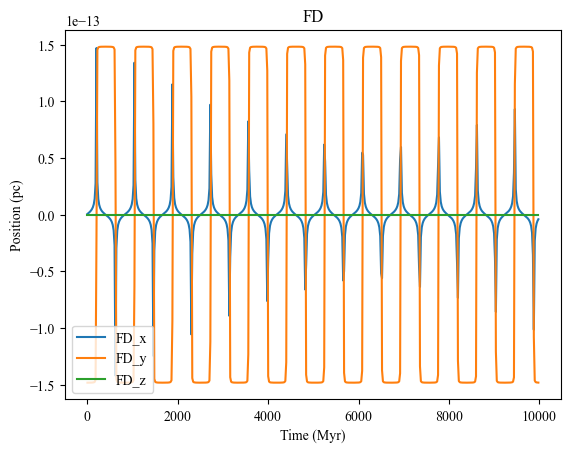

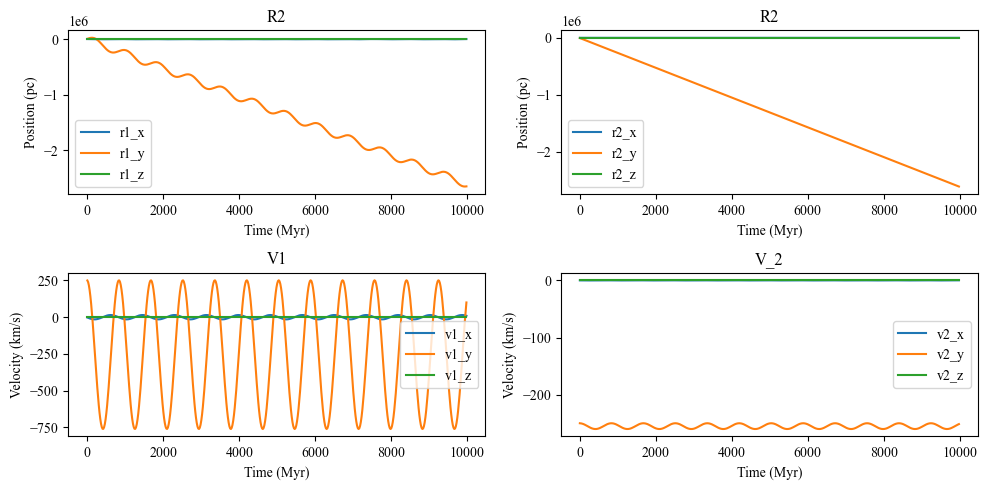

DF values:
[ 6.45440602e-16 -1.48247380e-13  0.00000000e+00]
[ 1.30529542e-15 -1.48243039e-13  0.00000000e+00]
[ 2.01164613e-15 -1.48235136e-13  0.00000000e+00]
[ 2.80599496e-15 -1.48222228e-13  0.00000000e+00]
[ 3.75039480e-15 -1.48201339e-13  0.00000000e+00]
[ 4.95031680e-15 -1.48166112e-13  0.00000000e+00]
[ 6.61031619e-15 -1.48101337e-13  0.00000000e+00]
[ 9.19826437e-15 -1.47963152e-13  0.00000000e+00]
[ 1.40874454e-14 -1.47577933e-13  0.00000000e+00]
[ 2.77807941e-14 -1.45622560e-13  0.00000000e+00]
[ 1.47044418e-13 -1.88584633e-14  0.00000000e+00]
[2.85367595e-14 1.45476306e-13 0.00000000e+00]
[1.38068375e-14 1.47604450e-13 0.00000000e+00]
[8.71628741e-15 1.47992327e-13 0.00000000e+00]
[6.05740390e-15 1.48124982e-13 0.00000000e+00]
[4.36477899e-15 1.48184517e-13 0.00000000e+00]
[3.14749693e-15 1.48215369e-13 0.00000000e+00]
[2.19308675e-15 1.48232563e-13 0.00000000e+00]
[1.39279849e-15 1.48242243e-13 0.00000000e+00]
[6.83062608e-16 1.48247212e-13 0.00000000e+00]
[2.16524323e-17 

In [35]:
first_four_r1 = []
first_four_r2 = []
first_four_v1 = []
first_four_v2 = []
first_four_F_D = []

for i in range(N):
    dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) - F_D1
    dv2bydt=((G*m1*(r2-r1))/r**3).to(u.km / u.s**2) - F_D2
    v1 += dv1bydt * delta_t
    v2 += dv2bydt * delta_t

    r1 += v1.to(u.pc / u.s) * delta_t
    r2 += v2.to(u.pc / u.s) * delta_t

    F_D = 0.428 * ln_A * ((G * m1**(2))/r**(2))

    v_r = v2 - v1

    v_rmag = np.linalg.norm(v_r) 

    v_rel_unit = (v_r / v_rmag)

    F_D_i = (F_D * v_rel_unit[0])
    F_D_j = (F_D * v_rel_unit[1])
    F_D_k = (F_D * v_rel_unit[2])
    
    F_D = np.array([F_D_i.to((u.kg*u.m)/(u.s**2)).value, F_D_j.to((u.kg*u.m)/ (u.s**2)).value, F_D_k.to((u.kg*u.m)/ (u.s**2)).value])


    F_D = F_D * ((u.kg * u.m)/(u.s**2))

    first_four_F_D.append([

        (F_D_i.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D_j.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D_k.to((u.kg * u.m) / (u.s**2))/m1).value
    ])

    first_four_r1.append(r1.copy())
    first_four_r2.append(r2.copy())
    first_four_v1.append(v1.copy())
    first_four_v2.append(v2.copy())


time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit


first_four_r1 = np.array(first_four_r1)  
first_four_r2 = np.array(first_four_r2)  
first_four_v1 = np.array(first_four_v1)  
first_four_v2 = np.array(first_four_v2) 
first_four_F_D = np.array(first_four_F_D) 


# region
plt.plot(time_values, first_four_F_D[:, 0], label="FD_x")
plt.plot(time_values, first_four_F_D[:, 1], label="FD_y")
plt.plot(time_values, first_four_F_D[:, 2], label="FD_z")
plt.title("FD")
plt.xlabel("Time (Myr)")
plt.ylabel("Position (pc)")
plt.legend()

fig, axs = plt.subplots(2, 2, figsize=(10, 5))


axs[0, 0].plot(time_values, first_four_r1[:, 0], label="r1_x")
axs[0, 0].plot(time_values, first_four_r1[:, 1], label="r1_y")
axs[0, 0].plot(time_values, first_four_r1[:, 2], label="r1_z")
axs[0, 0].set_title("R2")
axs[0, 0].set_xlabel("Time (Myr)")
axs[0, 0].set_ylabel("Position (pc)")
axs[0, 0].legend()


axs[0, 1].plot(time_values, first_four_r2[:, 0], label="r2_x")
axs[0, 1].plot(time_values, first_four_r2[:, 1], label="r2_y")
axs[0, 1].plot(time_values, first_four_r2[:, 2], label="r2_z")
axs[0, 1].set_title("R2")
axs[0, 1].set_xlabel("Time (Myr)")
axs[0, 1].set_ylabel("Position (pc)")
axs[0, 1].legend()


axs[1, 0].plot(time_values, first_four_v1[:, 0], label="v1_x")
axs[1, 0].plot(time_values, first_four_v1[:, 1], label="v1_y")
axs[1, 0].plot(time_values, first_four_v1[:, 2], label="v1_z")
axs[1, 0].set_title("V1")
axs[1, 0].set_xlabel("Time (Myr)")
axs[1, 0].set_ylabel("Velocity (km/s)")
axs[1, 0].legend()


axs[1, 1].plot(time_values, first_four_v2[:, 0], label="v2_x")
axs[1, 1].plot(time_values, first_four_v2[:, 1], label="v2_y")
axs[1, 1].plot(time_values, first_four_v2[:, 2], label="v2_z")
axs[1, 1].set_title("V_2")
axs[1, 1].set_xlabel("Time (Myr)")
axs[1, 1].set_ylabel("Velocity (km/s)")
axs[1, 1].legend()


plt.tight_layout()
plt.show()

# endregion

print("DF values:")
for val in first_four_F_D:
    print(val)
    

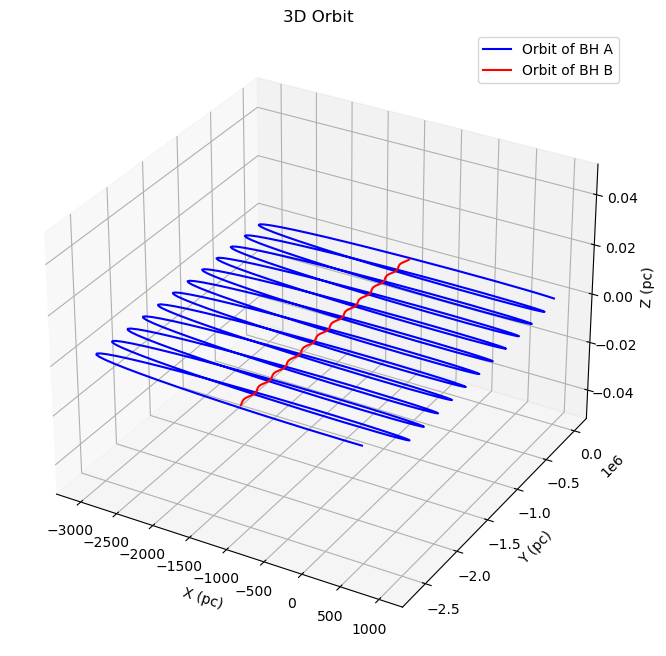

In [9]:
from mpl_toolkits.mplot3d import Axes3D  


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.plot(first_four_r1[:, 0], first_four_r1[:, 1], first_four_r1[:, 2], label="Orbit of BH A", color="blue")


ax.plot(first_four_r2[:, 0], first_four_r2[:, 1], first_four_r2[:, 2], label="Orbit of BH B", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit')


ax.legend()


plt.show()

/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_14066/338675602.py:24: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim([np.min(first_four_r1[:, 2]), np.max(first_four_r1[:, 2])])


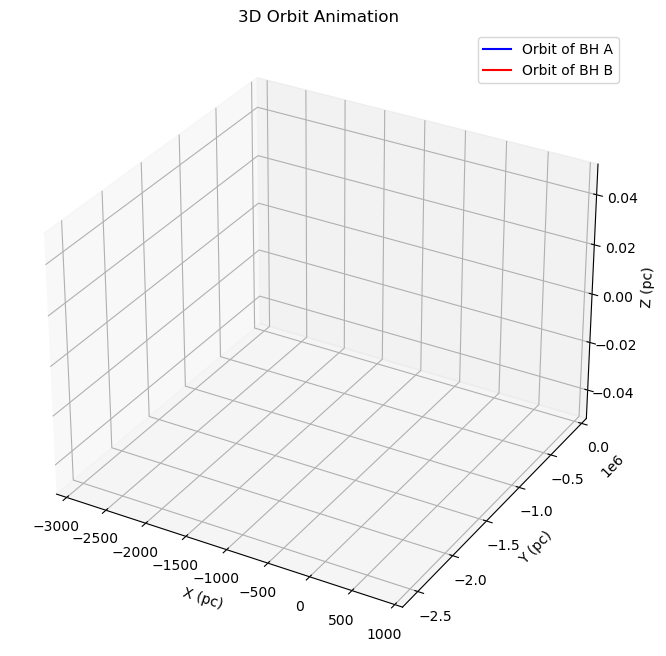

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit Animation')


line1, = ax.plot([], [], [], label="Orbit of BH A", color="blue")
line2, = ax.plot([], [], [], label="Orbit of BH B", color="red")
ax.legend()

# Limits for the plot (adjust as needed based on data)
ax.set_xlim([np.min(first_four_r1[:, 0]), np.max(first_four_r1[:, 0])])
ax.set_ylim([np.min(first_four_r1[:, 1]), np.max(first_four_r1[:, 1])])
ax.set_zlim([np.min(first_four_r1[:, 2]), np.max(first_four_r1[:, 2])])


def update(num):

    line1.set_data(first_four_r1[:num, 0], first_four_r1[:num, 1])
    line1.set_3d_properties(first_four_r1[:num, 2])
    
    line2.set_data(first_four_r2[:num, 0], first_four_r2[:num, 1])
    line2.set_3d_properties(first_four_r2[:num, 2])
    
    return line1, line2


ani = FuncAnimation(fig, update, frames=len(first_four_r1), interval=50, blit=True)


plt.show()


ani.save("black_hole_orbits.mp4", writer="ffmpeg", fps=20)  # Adjust fps as needed

Magnitude of Velocity

In [10]:
first_four_v1[:,0]

array([ -2.19930021,  -4.34962731,  -6.40309871,  -8.31398856,
       -10.03974596, -11.54194246, -12.78712777, -13.74757461,
       -14.40189616, -14.73552225, -14.74102384, -14.41827841,
       -13.77447274, -12.82394282, -11.58785465, -10.09373293,
        -8.37484815,  -6.46947573,  -4.4200437 ,  -2.27218796,
        -0.07373609,   2.12635771,   4.27910265,   6.33656231,
         8.25292203,   9.9855091 ,  11.49574299,  12.74999443,
        13.72033429,  14.38515542,  14.72965388,  14.7461585 ,
        14.43430178,  13.80102801,  12.86043866,  11.6334784 ,
        10.14746866,   8.43549929,   6.53569171,   4.49035007,
         2.34501916,   0.14747035,  -2.05336228,  -4.20847148,
        -6.26986819,  -8.19165007,  -9.93102368, -11.44925737,
       -12.71254374, -13.69275245, -14.36805663, -14.72341887,
       -14.75092613, -14.44996587, -13.82723976, -12.8966144 ,
       -11.67881258, -10.2009518 ,  -8.49594045,  -6.60174502,
        -4.56054467,  -2.41779199,  -0.22120093,   1.98

In [11]:
N

500

[250.10323755 238.97838303 216.87861845 184.31035011 142.03734132
  91.14091182  33.94059855  36.58817917 105.16920014 178.418753
 253.5887748  328.86903518 402.54469377 472.95988526 538.53928115
 597.81858221 649.47540757 692.35799383 725.51048082 748.19400788
 759.90306403 760.37668886 749.6042568  727.82570851 695.52622285
 653.42545314 602.46158084 543.77057175 478.66116463 408.58631351
 335.11216713 259.88670631 184.61451548 111.07248762  41.63529914
  28.68083567  86.3654299  137.98783619 181.06401378 214.50069922
 237.51821976 249.59157798 250.44768337 240.06785105 218.68828396
 186.79849432 145.14444074  94.78005798  37.79535928  32.40633576
 100.39485686 173.44425915 248.54424733 323.87120802 397.70640918
 468.38957283 534.33906898 594.08220379 646.28618855 689.78703095
 723.61507599 747.01640156 759.46949974 760.69683143 750.67097829
 729.61524663 697.99870841 656.52579419 606.12068249 547.90686175
 483.1823841  413.39151657 340.09383759 264.932782   189.60954796
 115.8928192

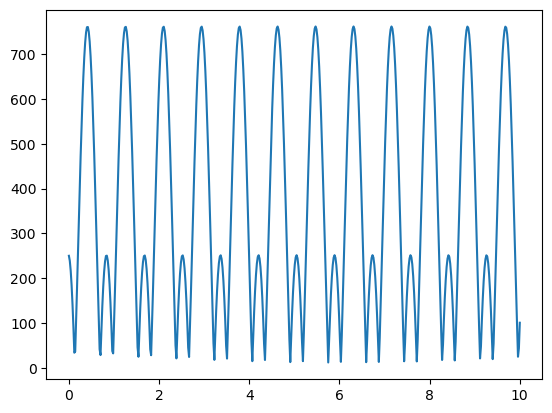

In [12]:
vmag = np.sqrt(first_four_v1[:,0]**2 + first_four_v1[:,1]**2 + first_four_v1[:,2]**2)
v_mag1 = np.linalg.norm(first_four_v1)


print(vmag)
print(v_mag1)

plt.plot(time_span, vmag)

In [13]:




initial = first_four_v1[0,0]
final = first_four_v1[-1,0]

change = ((final - initial) / initial) * 100

print(f"Percent change in X for BH A = {change:4f} %")



Percent change in X for BH A = -541.689848 %


In [14]:
first_four_v1 = np.array(first_four_v1)  



initial = first_four_v1[0,1]
final = first_four_v1[-1,1]

change = ((final - initial) / initial) * 100

print(f"Percent change in Y for BH A = {change:4f} %")



Percent change in Y for BH A = -59.881124 %


In [15]:

first_four_v2 = np.array(first_four_v2) 


initial = first_four_v2[0,0]
final = first_four_v2[-1,0]

change = ((final - initial) / initial) * 100

print(f"Percent change in X for BH B = {change:4f} %")

Percent change in X for BH B = -541.689848 %


In [16]:

first_four_v2 = np.array(first_four_v2) 


initial = first_four_v2[0,1]
final = first_four_v2[-1,1]

change = ((final - initial) / initial) * 100

print(f"Percent change in X for BH B = {change:4f} %")

Percent change in X for BH B = 0.599038 %


Now we have the IC's

In [17]:
G = const.G #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=1e6 * const.M_sun #mass of black hole A 
m2=1e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
mu = G.value * (m1.value+m2.value)
#r_i
r1=[6e3,0,0] * u.pc
r2=[-6e3,0,0] * u.pc
#To arrays
r1=np.array(r1,dtype="float64")
r2=np.array(r2,dtype="float64")

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)
#V_i
v1=[0,1e3, 0] *u.km/u.s
v2=[0,-1e3,0] *u.km/u.s #km/s

# v1 = v1.to(u.m / u.year)
# v2 = v2.to(u.m / u.year)

#To arrays
v1=np.array(v1,dtype="float64") *u.km/u.s
v2=np.array(v2,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

T = 10 *u.Myr  # we can extract a from here - whole time in seconds
N = 50000
delta_t = T/ N

In [18]:
delta_t = delta_t.to(u.s)

r=np.linalg.norm(r2-r1) * u.pc
a1 = (np.linalg.norm(r2 - r1) / 2) * u.pc

o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
x = (a1 * o**(2)) / (G * m1)
ln_A = math.log10(x.to_value(u.dimensionless_unscaled))
F_D = 0.428 * ln_A * ((G * m1**(2))/r**(2)).to(u.kg *u.m / (u.s**2))
a1 = (F_D/m1).to(u.km/u.s**2)
a2 = (F_D/m2).to(u.km/u.s**2)

# dr1bydt=v1 - (a1 * delta_t)
# dr2bydt=v2 - (a2 * delta_t)

dr1bydt = v1 - (a1 * delta_t)
dr2bydt = v2 - (a2 * delta_t)

print(dr1bydt)  # Check resulting velocity
print(dr2bydt)

[-1.23895805e-08  1.00000000e+03 -1.23895805e-08] km / s
[-1.23895805e-10 -1.00000000e+03 -1.23895805e-10] km / s


In [19]:
o = (10**(2.2969)*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
x = (215*u.pc * o**(2)) / (G * m2)
ln_A = math.log10(x.to(""))
print(x)
print(ln_A)

6.358092265577657e-22 km2 pc / m3
1.2926773711193107


We can then check to make sure the T & N are in a good area to not cause mishaps within the plots

In [20]:
# cfl_check = verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2)
# print(f"CFL  Satisfied: {cfl_check}")

Now the bulk of the code for the plots with 6 different perspectives

/Users/naazshafeer/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


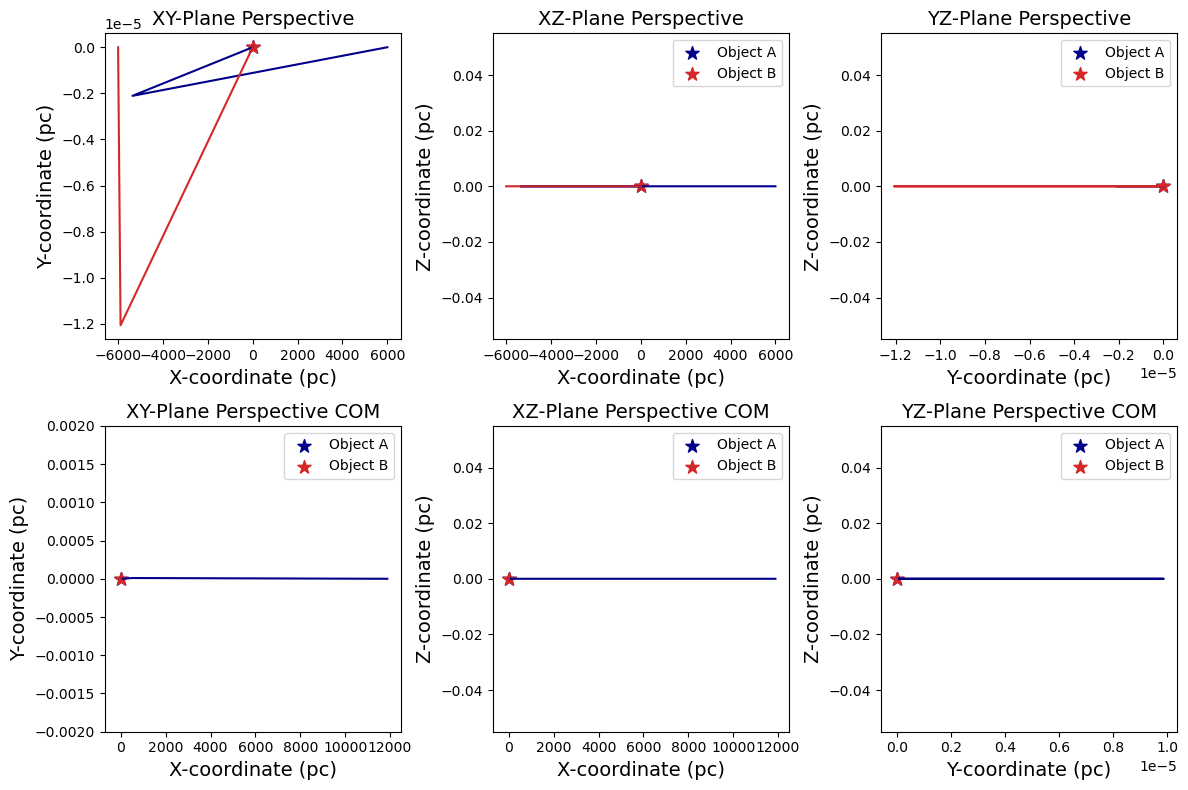

In [21]:
#Package initial parameters
init_params=np.array([r1,r2,v1,v2]) #create array of initial params
init_params=init_params.flatten() #flatten array to make it 1D
time_span=np.linspace(0, T, N) #Work on this with Kris' link


two_body_sol=sci.integrate.odeint(TwoBodyEquations,init_params,time_span,args=(G,m1,m2, m_gal)) #make sure to understand what is within this variable

r1_sol = two_body_sol[:, :3]
r2_sol = two_body_sol[:, 3:6]

#Find location of COM
rcom_sol=(m1.value*r1_sol+m2.value*r2_sol)/(m1.value+m2.value)

r1com_sol=r1_sol-rcom_sol

r2com_sol=r2_sol-rcom_sol  
#Create figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) #looked at article to see how I can line up three differnt persepctives in a row

# region Code Snippet 1: Plot the orbits for XY plane (0,1) in indices
axs[0,0].plot(r1_sol[:,0],r1_sol[:,1],color="darkblue")
axs[0,0].plot(r2_sol[:,0],r2_sol[:,1],color="tab:red")
axs[0,0].scatter(r1_sol[-1,0],r1_sol[-1,1],color="darkblue",marker="*",s=100)
axs[0,0].scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:red",marker="*",s=100)
axs[0,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[0,0].set_title("XY-Plane Perspective",fontsize=14)

# # Create an inset of the zoomed-in view on the center of mass within the specific subplot
# axins = inset_axes(axs[0, 0], width="30%", height="30%", loc='upper right')  # adjust width and height as needed

# # Plot the center of mass trajectory on the inset
# axins.plot(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple")
# axins.scatter(rcom_sol[-1, 0], rcom_sol[-1, 1], color="tab:purple", marker="o", s=100)

# # Set zoomed-in limits
# zoom_margin = 0.0001
# axins.set_xlim(rcom_sol[-1, 0] - zoom_margin, rcom_sol[-1, 0] + zoom_margin)
# axins.set_ylim(rcom_sol[-1, 1] - zoom_margin, rcom_sol[-1, 1] + zoom_margin)

# # Remove inset axis labels
# axins.set_xticklabels([])
# axins.set_yticklabels([])

# # Optionally, add a rectangle in the main plot to highlight the zoomed area
# axs[0, 0].indicate_inset_zoom(axins)

# endregion

# region Code Snippet 2: Plot the orbits for XZ plane (0,2) in indices
axs[0,1].plot(r1_sol[:,0],r1_sol[:,2],color="darkblue")
axs[0,1].plot(r2_sol[:,0],r2_sol[:,2],color="tab:red")
axs[0,1].scatter(r1_sol[-1,0],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,1].scatter(r2_sol[-1,0],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,1].set_title("XZ-Plane Perspective",fontsize=14)
axs[0,1].legend()
# endregion

# region Code Snippet 3: Plot the orbits for YZ plane (1,2) in indices
axs[0,2].plot(r1_sol[:,1],r1_sol[:,2],color="darkblue")
axs[0,2].plot(r2_sol[:,1],r2_sol[:,2],color="tab:red")
axs[0,2].scatter(r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,2].scatter(r2_sol[-1,1],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[0,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,2].set_title("YZ-Plane Perspective",fontsize=14)
axs[0,2].legend()
# endregion

# region Code Snippet 4: Plot the orbits for XY plane (0,1) in indices but COM
axs[1,0].plot(r1com_sol[:,0],r1com_sol[:,1],color="darkblue")
axs[1,0].plot(r2com_sol[:,0],r2com_sol[:,1],color="tab:red")
axs[1,0].set_ylim([-0.002, 0.002])
# axs[1,0].scatter(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple", marker = "*", s = 100, label="Center of Mass Trajectory")
axs[1,0].scatter(r1com_sol[-1,0],r1com_sol[-1,1],color="darkblue",marker="*",s=100,label="Object A")
axs[1,0].scatter(r2com_sol[-1,0],r2com_sol[-1,1],color="tab:red",marker="*",s=100,label="Object B")
axs[1,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[1,0].set_title("XY-Plane Perspective COM",fontsize=14)
axs[1,0].legend()

# endregion

# region Code Snippet 5: Plot the orbits for XZ plane (0,2) in indices but COM
axs[1,1].plot(r1com_sol[:,0],r1com_sol[:,2],color="darkblue")
axs[1,1].plot(r2com_sol[:,0],r2com_sol[:,2],color="tab:red")
axs[1,1].scatter(r1com_sol[-1,0],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,1].scatter(r2com_sol[-1,0],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,1].set_title("XZ-Plane Perspective COM",fontsize=14)
axs[1,1].legend()
# endregion

# region Code Snippet 6: Plot the orbits for YZ plane (1,2) in indices but COM
axs[1,2].plot(r1com_sol[:,1],r1com_sol[:,2],color="darkblue")
axs[1,2].plot(r2com_sol[:,1],r2com_sol[:,2],color="tab:red")
axs[1,2].scatter(r1com_sol[-1,1],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,2].scatter(r2com_sol[-1,1],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[1,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,2].set_title("YZ-Plane Perspective COM",fontsize=14)
axs[1,2].legend()
# endregion

plt.tight_layout() 
plt.show()



array([[ 0.00000000e+00,  1.00000000e+03,  0.00000000e+00],
       [-6.94363512e+12, -6.19803679e+04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

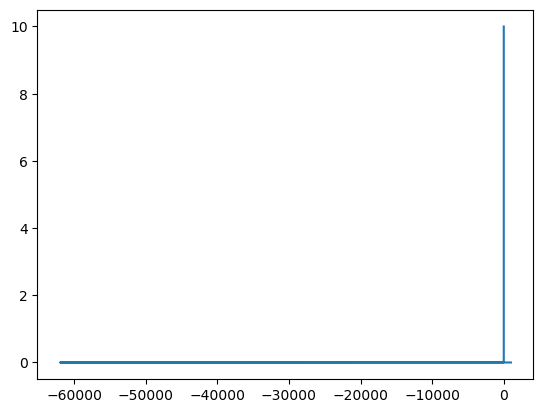

In [22]:
v1_sol = two_body_sol[:, 6:9]
v2_sol = two_body_sol[:, 9:12]


plt.plot(v1_sol[:,1], time_span) # 
v1_sol.shape
v1_sol

In [23]:
# t=np.linspace(0, T, N)
# F_D_all = np.zeros((len(t), 3))
# for i in range(len(t)):
#     r = np.linalg.norm(r2_sol[i] - r1_sol[i])
#     a1 = semi_major_axis(r1_sol[i], r2_sol[i])
#     o = sigma(m_gal.value)
#     ln_A = coulomb(a1, o, const.G.value, m1.value)
#     F_D = DF(v1_sol[i], v2_sol[i], ln_A, const.G.value, m1.value, r)
#     F_D_all[i] = F_D

# # Plot the dynamical friction force components
# plt.figure(figsize=(12, 6))

# plt.subplot(3, 1, 1)
# plt.plot(t, F_D_all[:, 0], label='F_D_x')
# plt.xlabel('Time (s)')
# plt.ylabel('F_D_x')
# plt.legend()

# plt.subplot(3, 1, 2)
# plt.plot(t, F_D_all[:, 1], label='F_D_y')
# plt.xlabel('Time (s)')
# plt.ylabel('F_D_y')
# plt.legend()

# plt.subplot(3, 1, 3)
# plt.plot(t, F_D_all[:, 2], label='F_D_z')
# plt.xlabel('Time (s)')
# plt.ylabel('F_D_z')
# plt.legend()

# plt.tight_layout()
# plt.show()

We can then do a plot to see how the positions of BH A moves (to make sure that we can cross-check this with the simulated orbit time)

In [24]:
from scipy.signal import find_peaks


y_relative_to_center = r1com_sol[:, 1]


peaks, _ = find_peaks(y_relative_to_center)


if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:.6f} years")


    plt.plot(time_span, r2_sol[:, 0], label='x')
    plt.plot(time_span, r2_sol[:, 1], label='y')
    plt.plot(time_span, r2_sol[:, 2], label='z')


    plt.scatter(time_span[peaks], r2_sol[peaks, 1], color='red', label='Peaks on y')

    plt.xlabel('Years')
    plt.ylabel('Position (m)')
    plt.title('Position Components of Black Hole B Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")

Could not find two peaks to determine the orbital period.


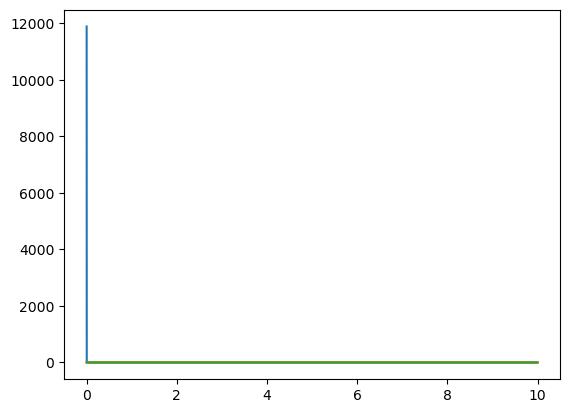

In [25]:
plt.plot(time_span, r1com_sol)

Now we can check the Theoretical Orbit Time

In [26]:
distance1 = np.linalg.norm(u.pc.to(u.m, r1_sol - r2_sol), axis= 1)

p_distance1 = np.min(distance1)
a_distance1 = np.max(distance1)

distance2 = np.linalg.norm(u.pc.to(u.m, r2com_sol), axis = 1)

p_distance2 = np.min(distance2)
a_distance2 = np.max(distance2)


# Theoretical data
# Eccentricity and Semi-Major Axis for Black Hole A
r_p1 = p_distance1
r_a1 = a_distance1
eccentricity1 = compute_eccentricity(r_p1, r_a1)
a1 = compute_semi_major_axis(r_p1, r_a1)

# Eccentricity and Semi-Major Axis for Black Hole B
r_p2 = p_distance2
r_a2 = a_distance2
eccentricity2 = compute_eccentricity(r_p2, r_a2)
a2 = compute_semi_major_axis(r_p2, r_a2)

# Semi Minor Axis for Black Hole A and B
b1 = compute_semi_minor_axis(a1, eccentricity1)
b2 = compute_semi_minor_axis(a2, eccentricity2)

# Orbital periods of the black holes
T1 = compute_orbital_period(a1, mu)
T2 = compute_orbital_period(a2, mu)


print(f"Eccentricity of the A orbit: {round(eccentricity1, 4)}") #WOOOOOOOH IT IS  0 < EPSILON < 1 !!!!
print(f"Eccentricity of the B orbit: {round(eccentricity2, 4)}") 
print(f"Semi-Major Axis of the orbit A: {round(u.m.to(u.pc,a1), 6)} pc")
print(f"Semi-Major Axis of the orbit B: {round(u.m.to(u.pc, a2), 6)} pc")
print(f"Semi-Minor Axis of the orbit A: {round(u.m.to(u.pc, b1), 6)} pc")
print(f"Semi-Minor Axis of the orbit B: {round(u.m.to(u.pc, b2), 6)} pc")
print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")



Eccentricity of the A orbit: 1.0
Eccentricity of the B orbit: 1.0
Semi-Major Axis of the orbit A: 6000.0 pc
Semi-Major Axis of the orbit B: 59.405941 pc
Semi-Minor Axis of the orbit A: 0.0 pc
Semi-Minor Axis of the orbit B: 0.0 pc
Theoretical Orbital Period of BH A: 4332235838.86501 yrs
Theoretical Orbital Period of BH B: 4268055.224189 yrs


Writing down the code for Dynamical Friction

In [27]:
r=np.linalg.norm(r2-r1)

print(r)

12000.0


In [28]:
import math
m_star = 10**(11) * const.M_sun
M_gal = 1e9 * const.M_sun #a billion solar mass?? 

r=np.linalg.norm(r2-r1) #Calculate magnitude or norm of vector
x_1 = (a1*10**(2.2969)*M_gal)/(const.G.value * m1.value* m_star)
x_2 = (a1*10**(2.2969)*M_gal)/(const.G.value * m1.value* m_star)

dv1bydt=(const.G.value*m2.value*(r2-r1)/r**3) - ((0.428*const.G.value*(m1.value+m2.value)**(2)*math.log(x_1))/r**2)
dv2bydt=(const.G.value*m1.value*(r1-r2)/r**3) - ((0.428*const.G.value*(m1.value+m2.value)**(2)*math.log(x_2))/r**2)




Now, we will compare with angles and positions and get the error

In [29]:
from scipy.signal import find_peaks
y_relative_to_center = u.pc.to(u.m, r1_sol[:, 1] - rcom_sol[:, 1])


peaks, _ = find_peaks(y_relative_to_center)

if len(peaks) >= 8:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:4f} years")


    plt.figure(figsize=(5, 3))
    plt.plot(time_span, y_relative_to_center, label='Y relative to center', color='purple')
    plt.scatter(time_span[peaks], y_relative_to_center[peaks], color='black', label='Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Y coordinate relative to center (m)')
    plt.title('Orbital Period Detection')
    plt.grid(True)
    plt.legend(loc = "upper right")
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")


Could not find two peaks to determine the orbital period.


In [30]:
#Calculations Using Positions

print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")
print(f"Simulated Orbital Period of BH A: {orbital_period_years} years")


percent_error = ((u.s.to(u.year, T1) - orbital_period_years) / u.s.to(u.year, T1)) * 100 * -1
print(f"Percent Error Using Positions = {round(percent_error, 4)} %")

Theoretical Orbital Period of BH A: 4332235838.86501 yrs
Theoretical Orbital Period of BH B: 4268055.224189 yrs


NameError: name 'orbital_period_years' is not defined

Now angles

None


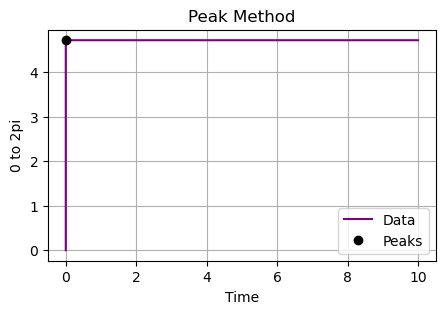

None


In [ ]:
from scipy.signal import find_peaks

#COM
# r1com_x = r1_sol_pc[:, 0] - rcom_sol[:, 0]
# r1com_y = r1_sol_pc[:, 1] - rcom_sol[:, 1]
# angles = np.arctan2(r1com_y, r1com_x)

c1y = (np.max(r1_sol[:,1]) + np.min(r1_sol[:,1])) / 2
c1x = (np.max(r1_sol[:,0]) + np.min(r1_sol[:,0])) / 2
c = np.array([u.pc.to(u.m,c1x), u.pc.to(u.m, c1y), 0])


angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  u.pc.to(u.m, rcom_sol[:,1]), u.pc.to(u.m, r1_sol[:, 0]) - u.pc.to(u.m, rcom_sol[:,0]))  # arctan2 gives the angle in radians

# angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  c[1], u.pc.to(u.m, r1_sol[:, 0]) - c[0]) #apparently, using the center of the ellipses and the COM does not have affect on teh orbital period?



angles_norm = angles - angles[0]
angles_norm = np.mod(angles_norm, 2 * np.pi)


peaks, _ = find_peaks(angles_norm)


if len(peaks) >= 2:
    orbital_period = time_span[peaks[1]] - time_span[peaks[0]]
    orbital_period_years = orbital_period 
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")


plt.figure(figsize=(5, 3))
plt.plot(time_span, angles_norm, label='Data', color = 'purple')
plt.plot(time_span[peaks], angles_norm[peaks], 'o', color='black', label='Peaks')
plt.xlim()
plt.xlabel('Time')
plt.ylabel('0 to 2pi')
plt.title('Peak Method')
plt.grid(True)
plt.legend()
plt.show()

if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    print(f"1st Peak Time: {first_peak_time:.2f} yrs (Index: {peaks[0]})")

    second_peak_time = time_span[peaks[1]]
    print(f"2nd Peak Time: {second_peak_time:.2f} yrs (Index: {peaks[1]})")

    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period 
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")

In [ ]:
#Calculations Using Angle


print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")
print(f"Simulated Orbital Period of BH A: {orbital_period_years} years")

percent_error = ((u.s.to(u.year, T1) - orbital_period_years) / u.s.to(u.year, T1)) * 100 
print(f"Percent Error Using Angles = {percent_error:4f} %")

Theoretical Orbital Period of BH A: 7129964981.522501 yrs
Theoretical Orbital Period of BH B: 887913.865513 yrs
Simulated Orbital Period of BH A: 0.0050001000019999076 years
Percent Error Using Angles = 100.000000 %


Now we do the Energy Calculations

In [ ]:
r1_sol

array([[ 3.24077929e-03,  0.00000000e+00,  0.00000000e+00],
       [ 3.24078163e-03, -5.92282128e+01,  0.00000000e+00],
       [ 3.24078260e-03, -8.37613420e+01,  0.00000000e+00],
       ...,
       [ 3.24130229e-03, -1.32434270e+04,  0.00000000e+00],
       [ 3.24130229e-03, -1.32435594e+04,  0.00000000e+00],
       [ 3.24130230e-03, -1.32436919e+04,  0.00000000e+00]])

In [ ]:
r1_sol

array([[ 3.24077929e-03,  0.00000000e+00,  0.00000000e+00],
       [ 3.24078163e-03, -5.92282128e+01,  0.00000000e+00],
       [ 3.24078260e-03, -8.37613420e+01,  0.00000000e+00],
       ...,
       [ 3.24130229e-03, -1.32434270e+04,  0.00000000e+00],
       [ 3.24130229e-03, -1.32435594e+04,  0.00000000e+00],
       [ 3.24130230e-03, -1.32436919e+04,  0.00000000e+00]])

The average energy would be 3.9539953629704823e+80 J
The fractional energy would be 8.10751117316013e-17 J
Using the Fractional Energy method, we get the percent change of 8.10751117316098e-15 %


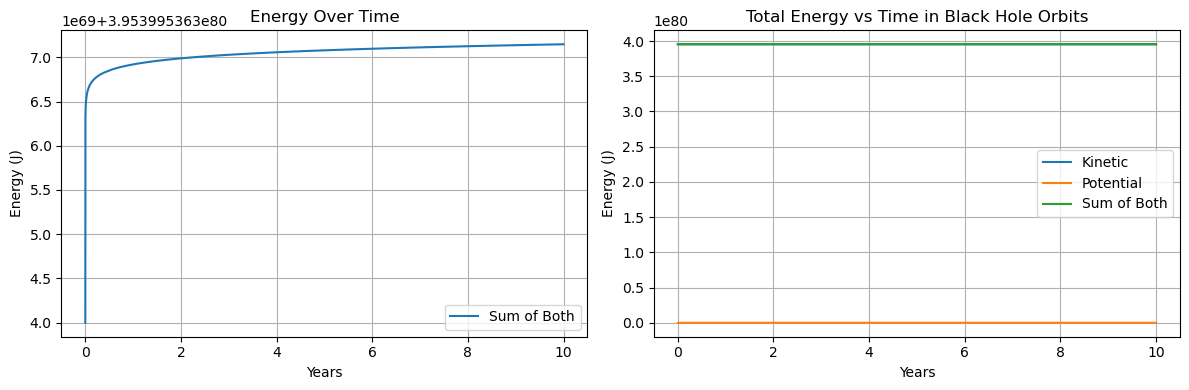

[3.95399536e+80 3.95399536e+80 3.95399536e+80 ... 3.95399536e+80
 3.95399536e+80 3.95399536e+80]


In [ ]:
v1_sol = u.year.to(u.s, two_body_sol[:, 6:9])
v2_sol = u.year.to(u.s, two_body_sol[:, 9:12])

KE = (0.5 * m1.value * np.sum(v1_sol**2, axis=1)) + (0.5 * m2.value * np.sum(v2_sol**2, axis=1))
V = -const.G.value * (m1.value + m2.value) / np.linalg.norm(u.pc.to(u.m, (r1_sol - r2_sol)), axis = 1)
E = V + KE

time_span_year = time_span
avg_energy = np.mean(E)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# region Code Snippet 6: Energy Graph Plot

axs[0].plot(time_span_year, E, label = "Sum of Both")
axs[0].set_xlabel("Years")
axs[0].set_ylabel("Energy (J)")
axs[0].set_title("Energy Over Time")
axs[0].legend()
axs[0].grid()

# endregion
# region Code Snippet 7: Energy Graph Plot

axs[1].plot(time_span_year, KE, label="Kinetic")
axs[1].plot(time_span_year, V, label = "Potential") 
axs[1].plot(time_span_year, E, label = "Sum of Both")
axs[1].set_xlabel("Years")
axs[1].set_ylabel("Energy (J)")
axs[1].set_title("Total Energy vs Time in Black Hole Orbits")
axs[1].legend()
axs[1].grid()
# endregion

#Fractional Energy work >

frac_energy = (E - avg_energy) / avg_energy
percent = frac_energy * 100

print(f"The average energy would be {round(avg_energy,6)} J")
print(f"The fractional energy would be {np.mean(frac_energy)} J")
print(f"Using the Fractional Energy method, we get the percent change of {np.mean(percent)} %")

plt.tight_layout()
plt.show()
print(KE)


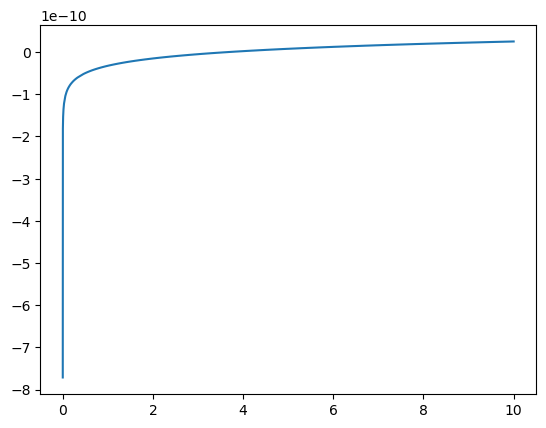

In [ ]:
plt.plot(time_span_year, percent)

Might need to make corrections on the energy plot(?)

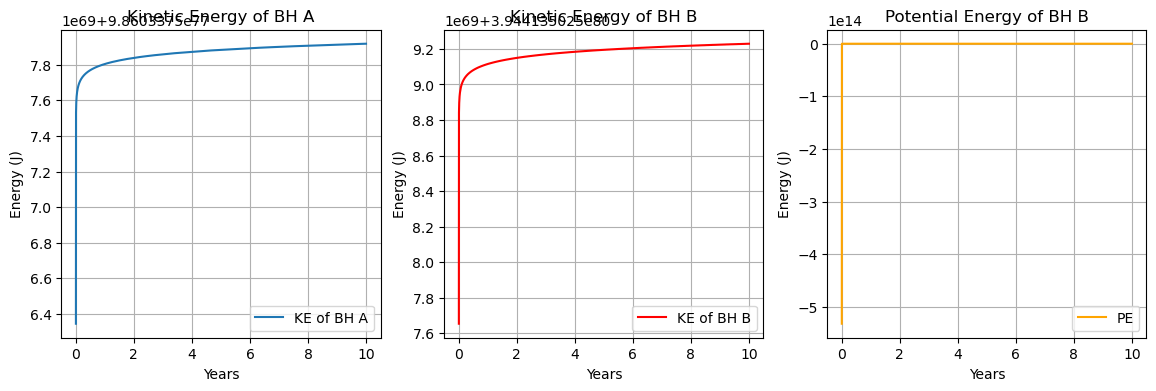

In [ ]:
KE_1 = 0.5 * m1.value * np.sum(v1_sol**2, axis=1)
KE_2 = 0.5 * m2.value * np.sum(v2_sol**2, axis=1)

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
# region Code Snippet 6: Energy Graph Plot

axs[0].plot(time_span_year, KE_1, label = "KE of BH A")
axs[0].set_xlabel("Years")
axs[0].set_ylabel("Energy (J)")
axs[0].set_title("Kinetic Energy of BH A")
axs[0].legend()
axs[0].grid()


axs[1].plot(time_span_year, KE_2, label = "KE of BH B", c = "red")
axs[1].set_xlabel("Years")
axs[1].set_ylabel("Energy (J)")
axs[1].set_title("Kinetic Energy of BH B")
axs[1].legend()
axs[1].grid()

axs[2].plot(time_span_year, V, label = "PE", c = "orange")
axs[2].set_xlabel("Years")
axs[2].set_ylabel("Energy (J)")
axs[2].set_title("Potential Energy of BH B")
axs[2].legend()
axs[2].grid()